In [ ]:
import os
from datetime import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 2.7 MB/s eta 0:00:00


In [ ]:
import patoolib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
control_1 = pd.read_csv('/content/drive/MyDrive/data/control/control_1.csv')  #path of control_1.csv
condition_1 = pd.read_csv('/content/drive/MyDrive/data/condition/condition_1.csv')#path of condition_1.csv
print(f'control_1.shape: {control_1.shape}')
print(f'condition_1.shape: {condition_1.shape}')

control_1.shape: (51611, 3)
condition_1.shape: (23244, 3)


In [ ]:
control_1.head()

timestamp        date  activity
0  2003-03-18 15:00:00  2003-03-18        60
1  2003-03-18 15:01:00  2003-03-18         0
2  2003-03-18 15:02:00  2003-03-18       264
3  2003-03-18 15:03:00  2003-03-18       662
4  2003-03-18 15:04:00  2003-03-18       293

In [ ]:
condition_1.head()

timestamp        date  activity
0  2003-05-07 12:00:00  2003-05-07         0
1  2003-05-07 12:01:00  2003-05-07       143
2  2003-05-07 12:02:00  2003-05-07         0
3  2003-05-07 12:03:00  2003-05-07        20
4  2003-05-07 12:04:00  2003-05-07       166

In [ ]:
condition_1.describe()

activity
count  23244.000000
mean     146.948030
std      294.592424
min        0.000000
25%        0.000000
50%        9.000000
75%      172.000000
max     3526.000000

<Axes: xlabel='activity', ylabel='Count'>

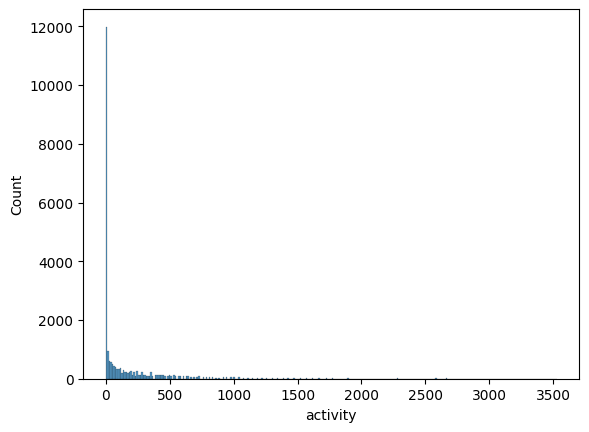

In [ ]:
sns.histplot(x='activity', data=condition_1)

In [ ]:
condition_1['activity'].skew()

3.8823677090908344

In [ ]:
condition_1['log_activity'] = np.log(condition_1['activity'] + 1) # add + 1 because log(0) is infinity
condition_1['log_activity'].skew()

0.2771381485812395

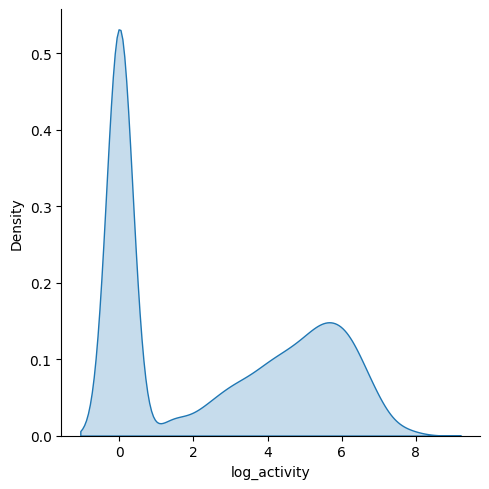

In [ ]:
sns.displot(x='log_activity', data=condition_1, kind='kde', fill=True)

In [ ]:
condition_1['sqrt_activity'] = np.sqrt(condition_1['activity'])
condition_1['sqrt_activity'].skew()

1.370447546298057

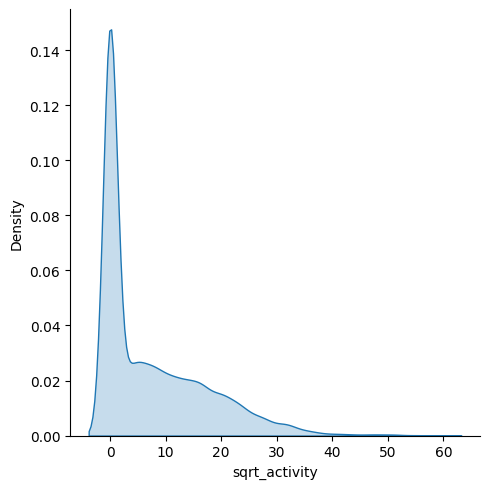

In [ ]:
sns.displot(x='sqrt_activity', data=condition_1, kind='kde', fill=True)

In [ ]:
condition_1.describe()

activity  log_activity  sqrt_activity
count  23244.000000  23244.000000   23244.000000
mean     146.948030      2.562035       7.416512
std      294.592424      2.626393       9.588917
min        0.000000      0.000000       0.000000
25%        0.000000      0.000000       0.000000
50%        9.000000      2.302585       3.000000
75%      172.000000      5.153292      13.114877
max     3526.000000      8.168203      59.380131

In [ ]:
control_1['activity'].skew()

5.039169993104665

In [ ]:
control_1.describe()

activity
count  51611.000000
mean      98.545078
std      289.655317
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max     6117.000000

In [ ]:
control_1['log_activity'] = np.log(control_1['activity'] + 1)
control_1['log_activity'].skew()

1.2517081703386566

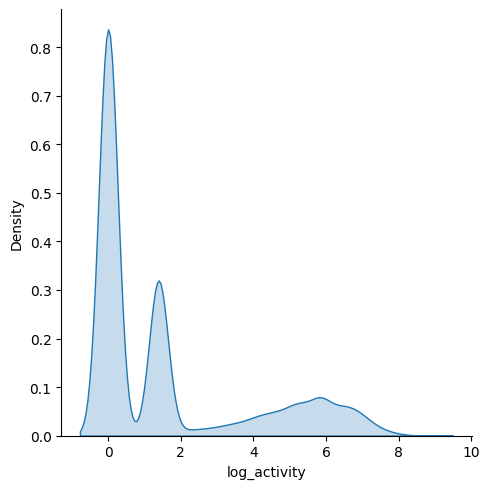

In [ ]:
sns.displot(x='log_activity', data=control_1, kind='kde', fill=True) #kernel density estimation

In [ ]:
condition_1.head()

timestamp        date  activity  log_activity  sqrt_activity
0  2003-05-07 12:00:00  2003-05-07         0      0.000000       0.000000
1  2003-05-07 12:01:00  2003-05-07       143      4.969813      11.958261
2  2003-05-07 12:02:00  2003-05-07         0      0.000000       0.000000
3  2003-05-07 12:03:00  2003-05-07        20      3.044522       4.472136
4  2003-05-07 12:04:00  2003-05-07       166      5.117994      12.884099

In [ ]:
df = condition_1.groupby('date')['log_activity'].mean().reset_index()
df.head()

date  log_activity
0  2003-05-07      3.752204
1  2003-05-08      2.931977
2  2003-05-09      2.593095
3  2003-05-10      2.910573
4  2003-05-11      2.561446

In [ ]:
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []
    
    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)
        
    return combine_df

In [ ]:
combine_df = combine_data('/content/drive/MyDrive/data/condition/')#path of condition folder

In [ ]:
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

In [ ]:
combine_df = combine_data('/content/drive/MyDrive/data/control/') #path of control folder

In [ ]:
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

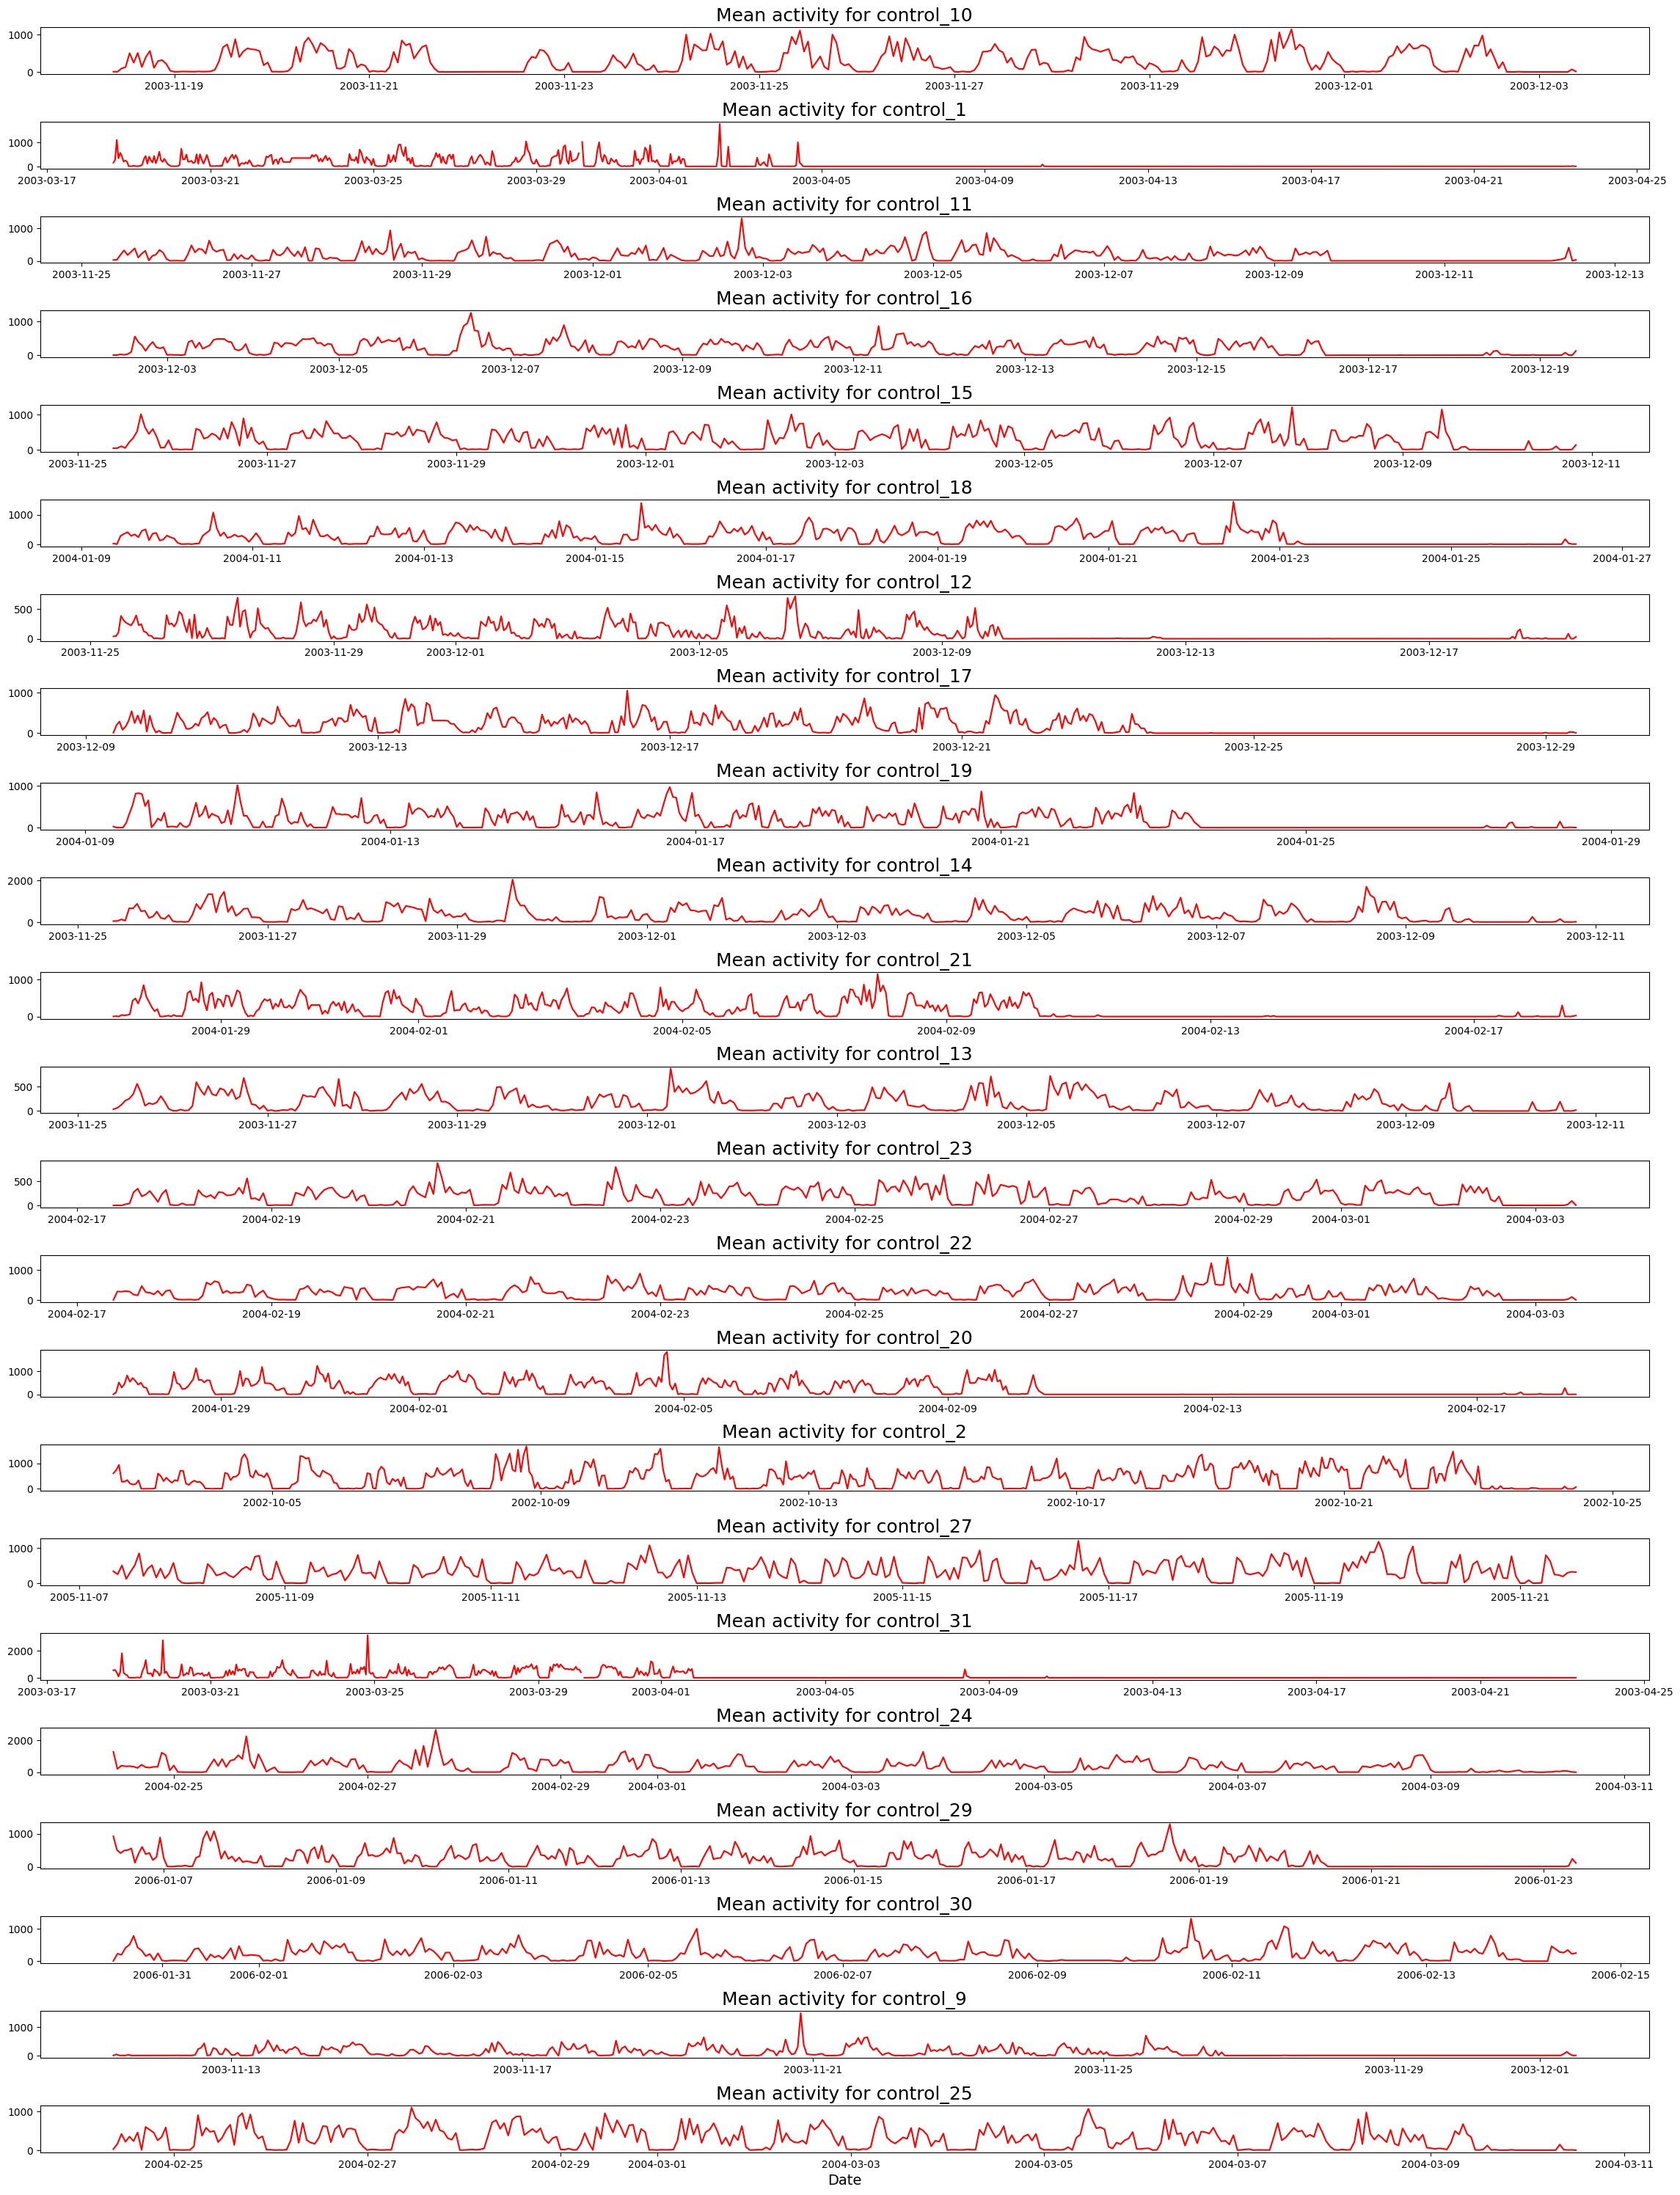

In [ ]:
fig, axes = plt.subplots(23, 1, figsize=(23, 30))
cnt = 0
for i in range(23):
    condition = conditions[cnt]
    axes[i].plot(condition.index, condition.mean_activity, color='r')
    axes[i].set_title(f'Mean activity for {condition.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of condition group.jpg', dpi=100)
plt.show()

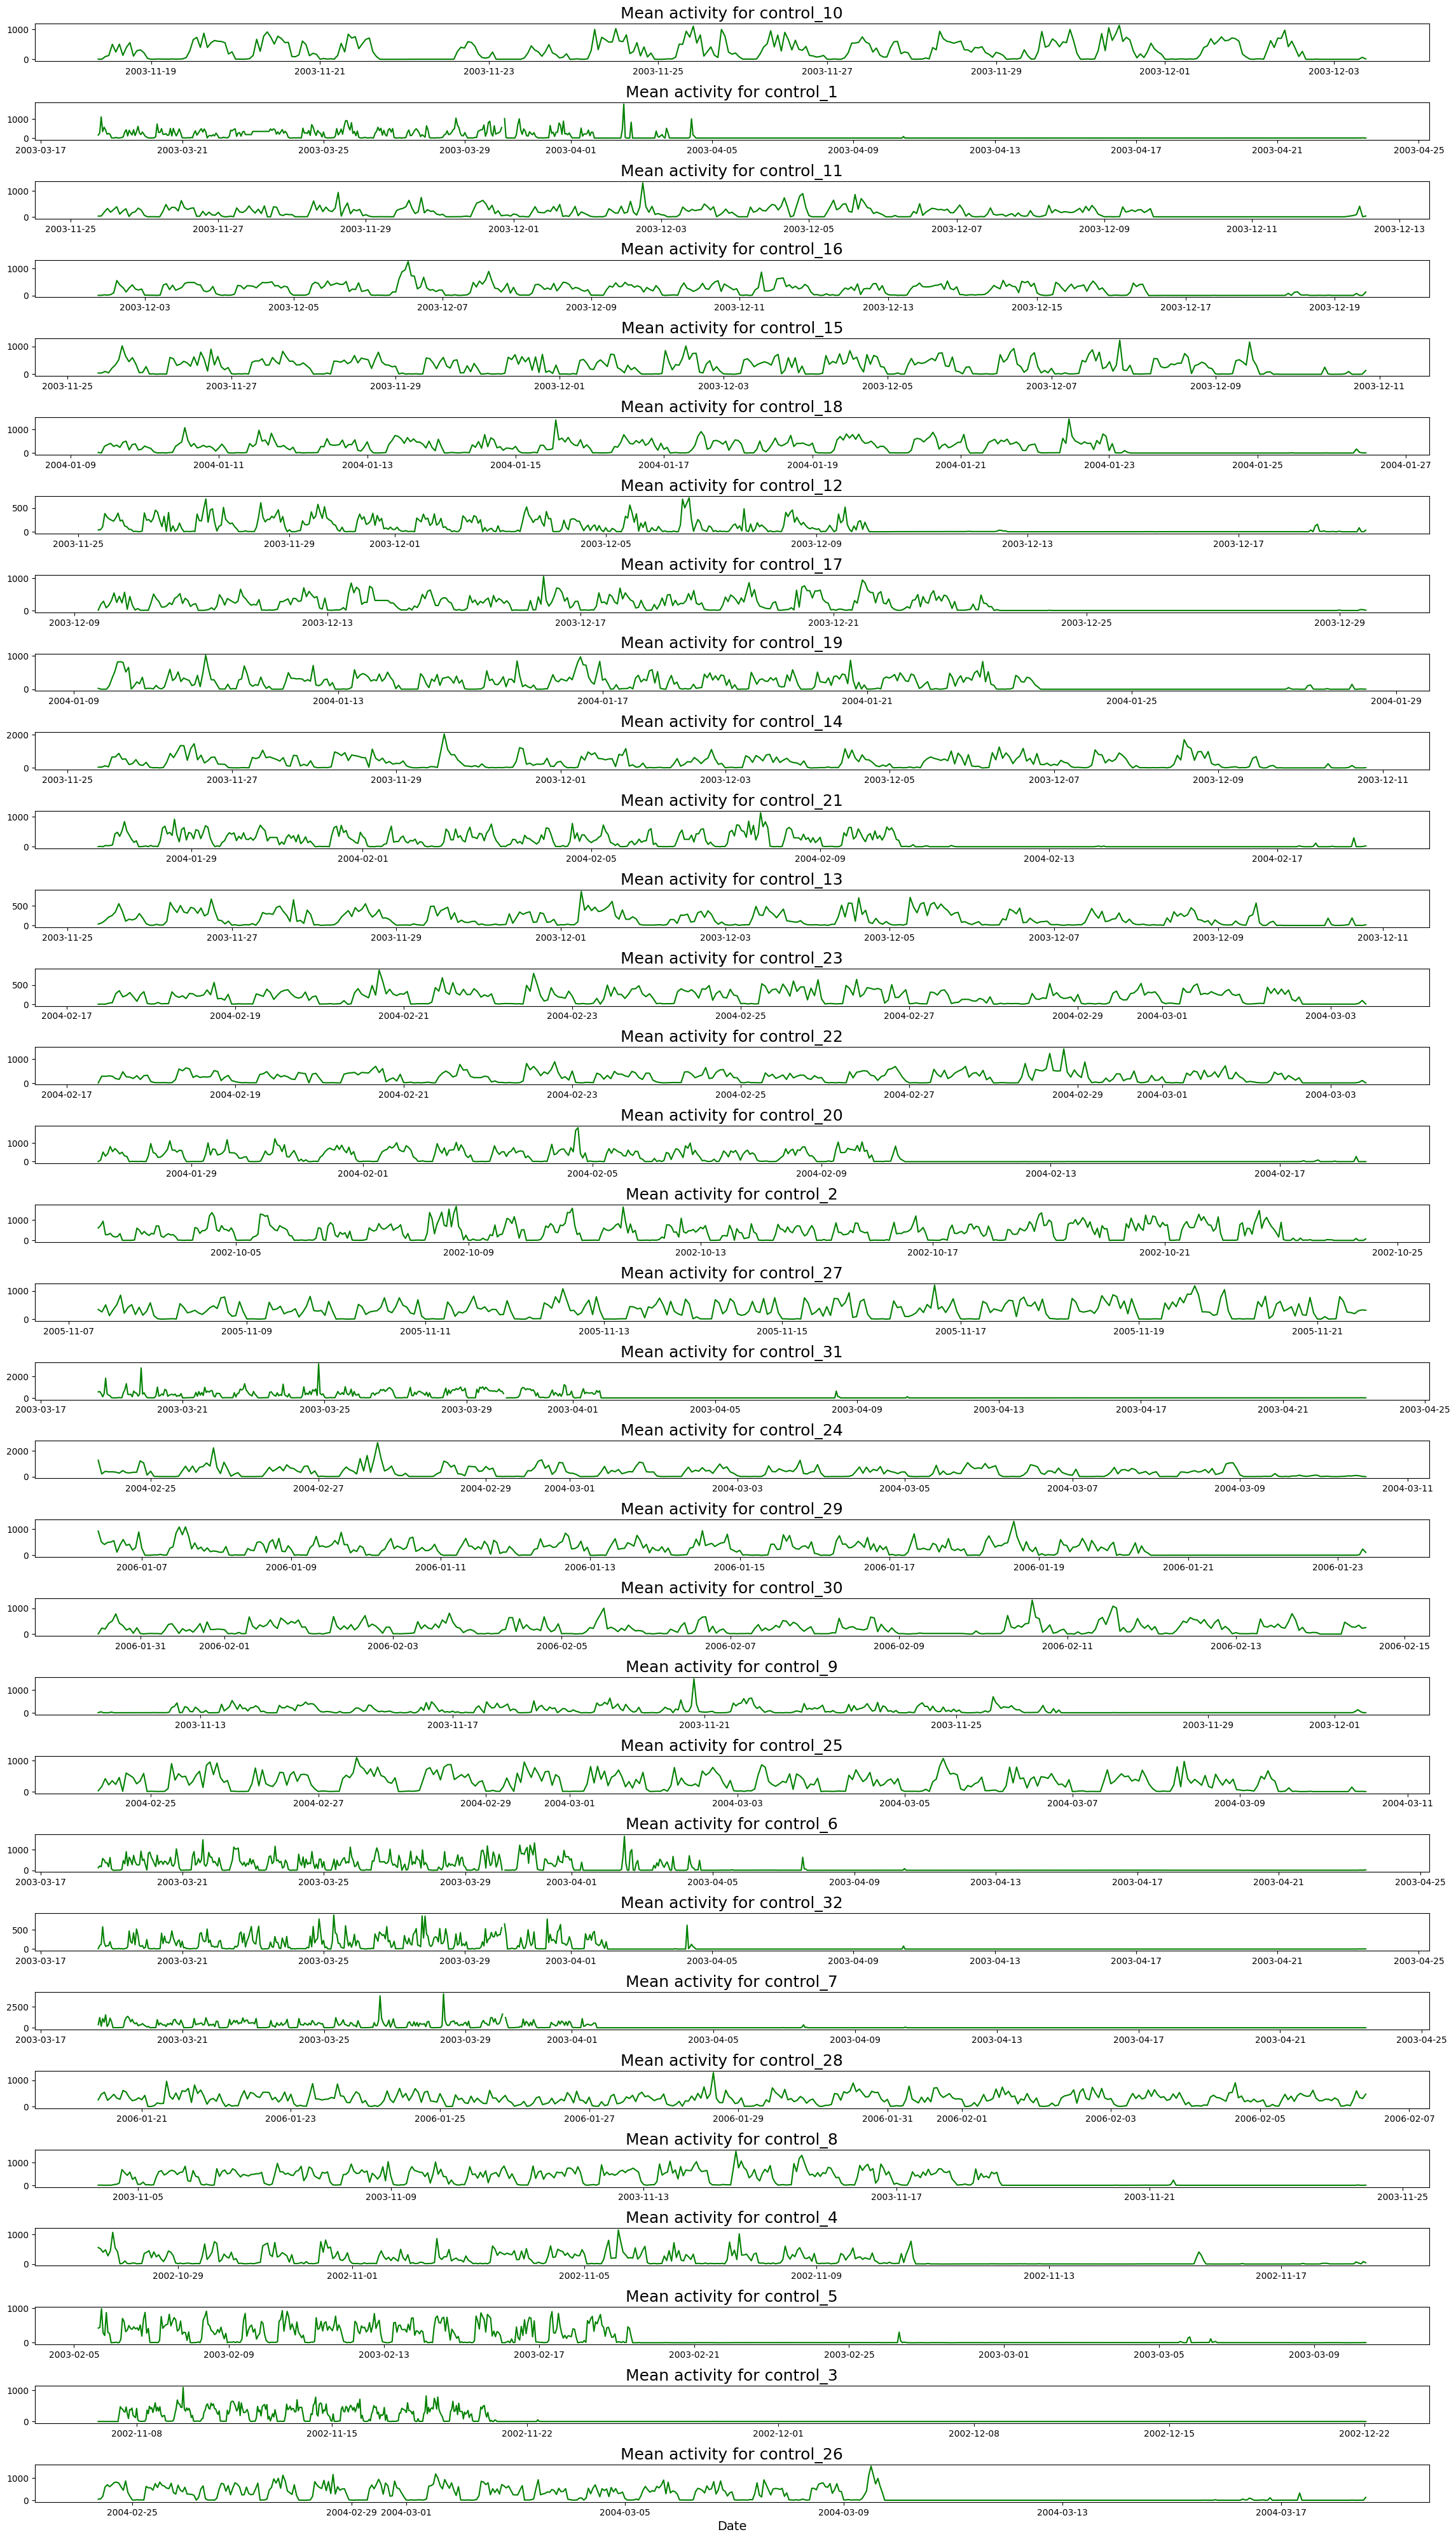

In [ ]:
fig, axes = plt.subplots(32, 1, figsize=(23, 40))
cnt = 0
for i in range(32):
    control = controls[cnt]
    axes[i].plot(control.index, control.mean_activity, color='g')
    axes[i].set_title(f'Mean activity for {control.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of control group.jpg', dpi=100)
plt.show()

In [ ]:
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

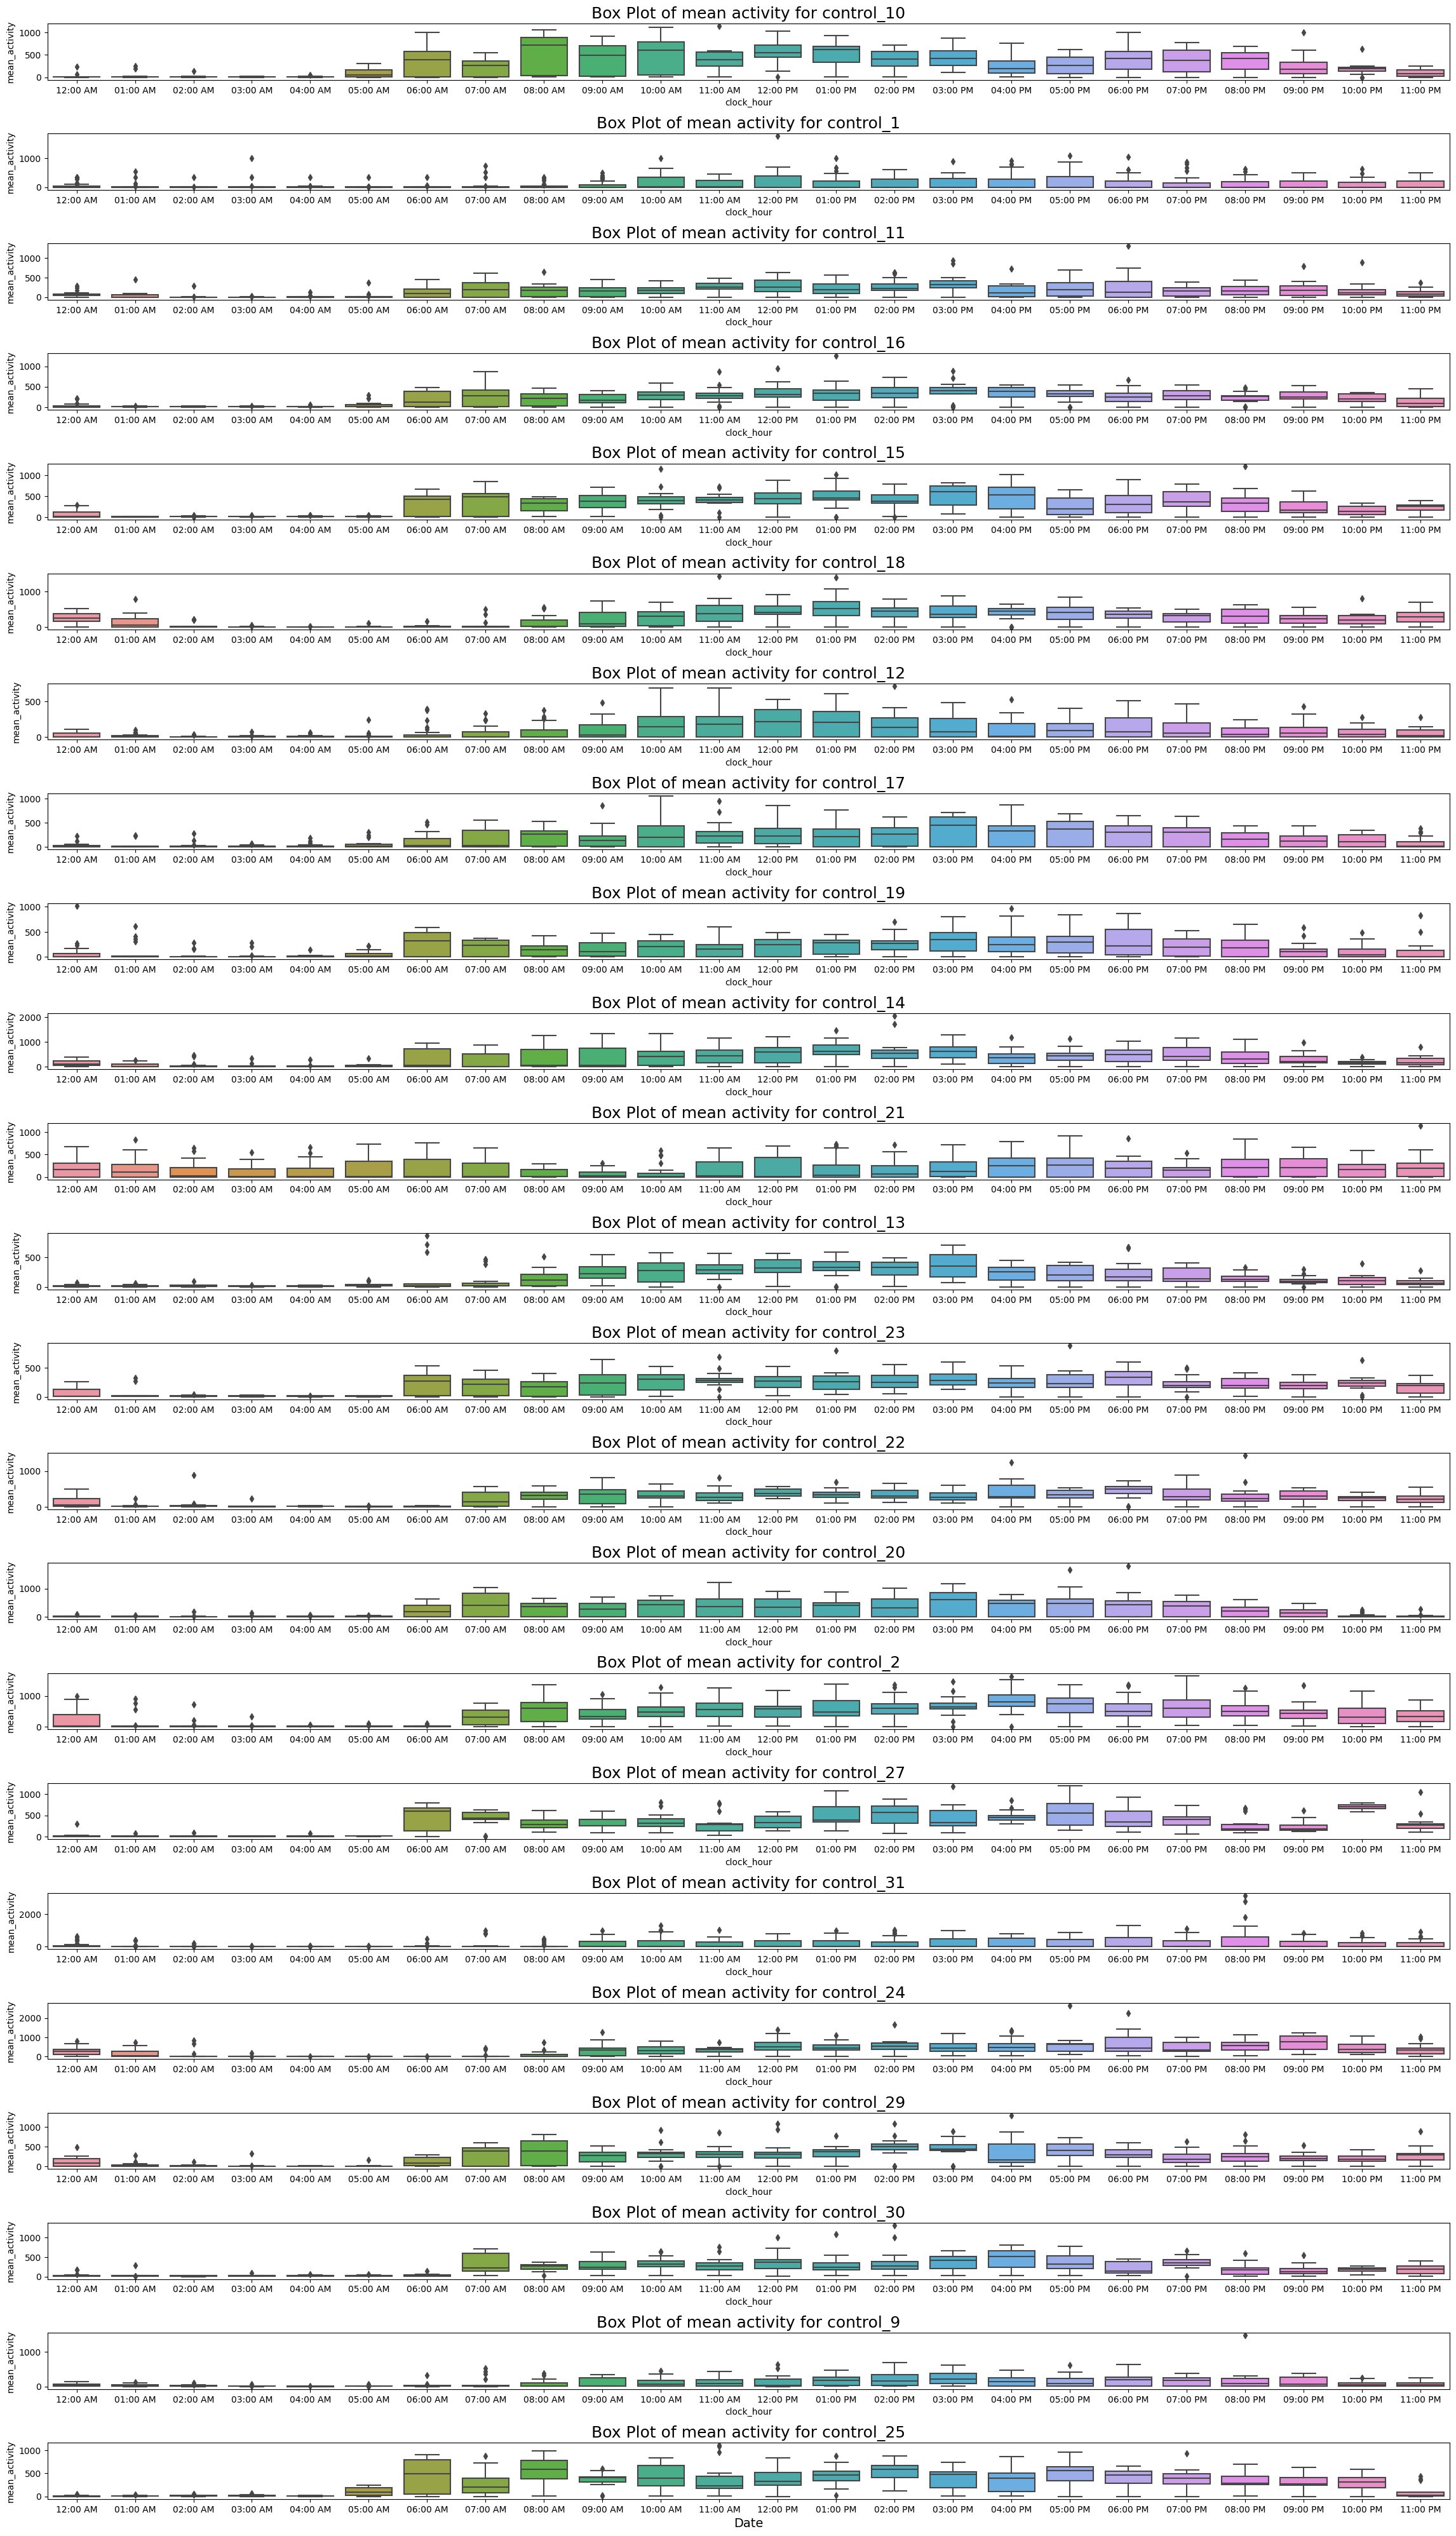

In [ ]:
# Draw Plot
fig, axes = plt.subplots(23, 1, figsize=(23, 40))

cnt = 0
for i in range(23):
    df = conditions[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

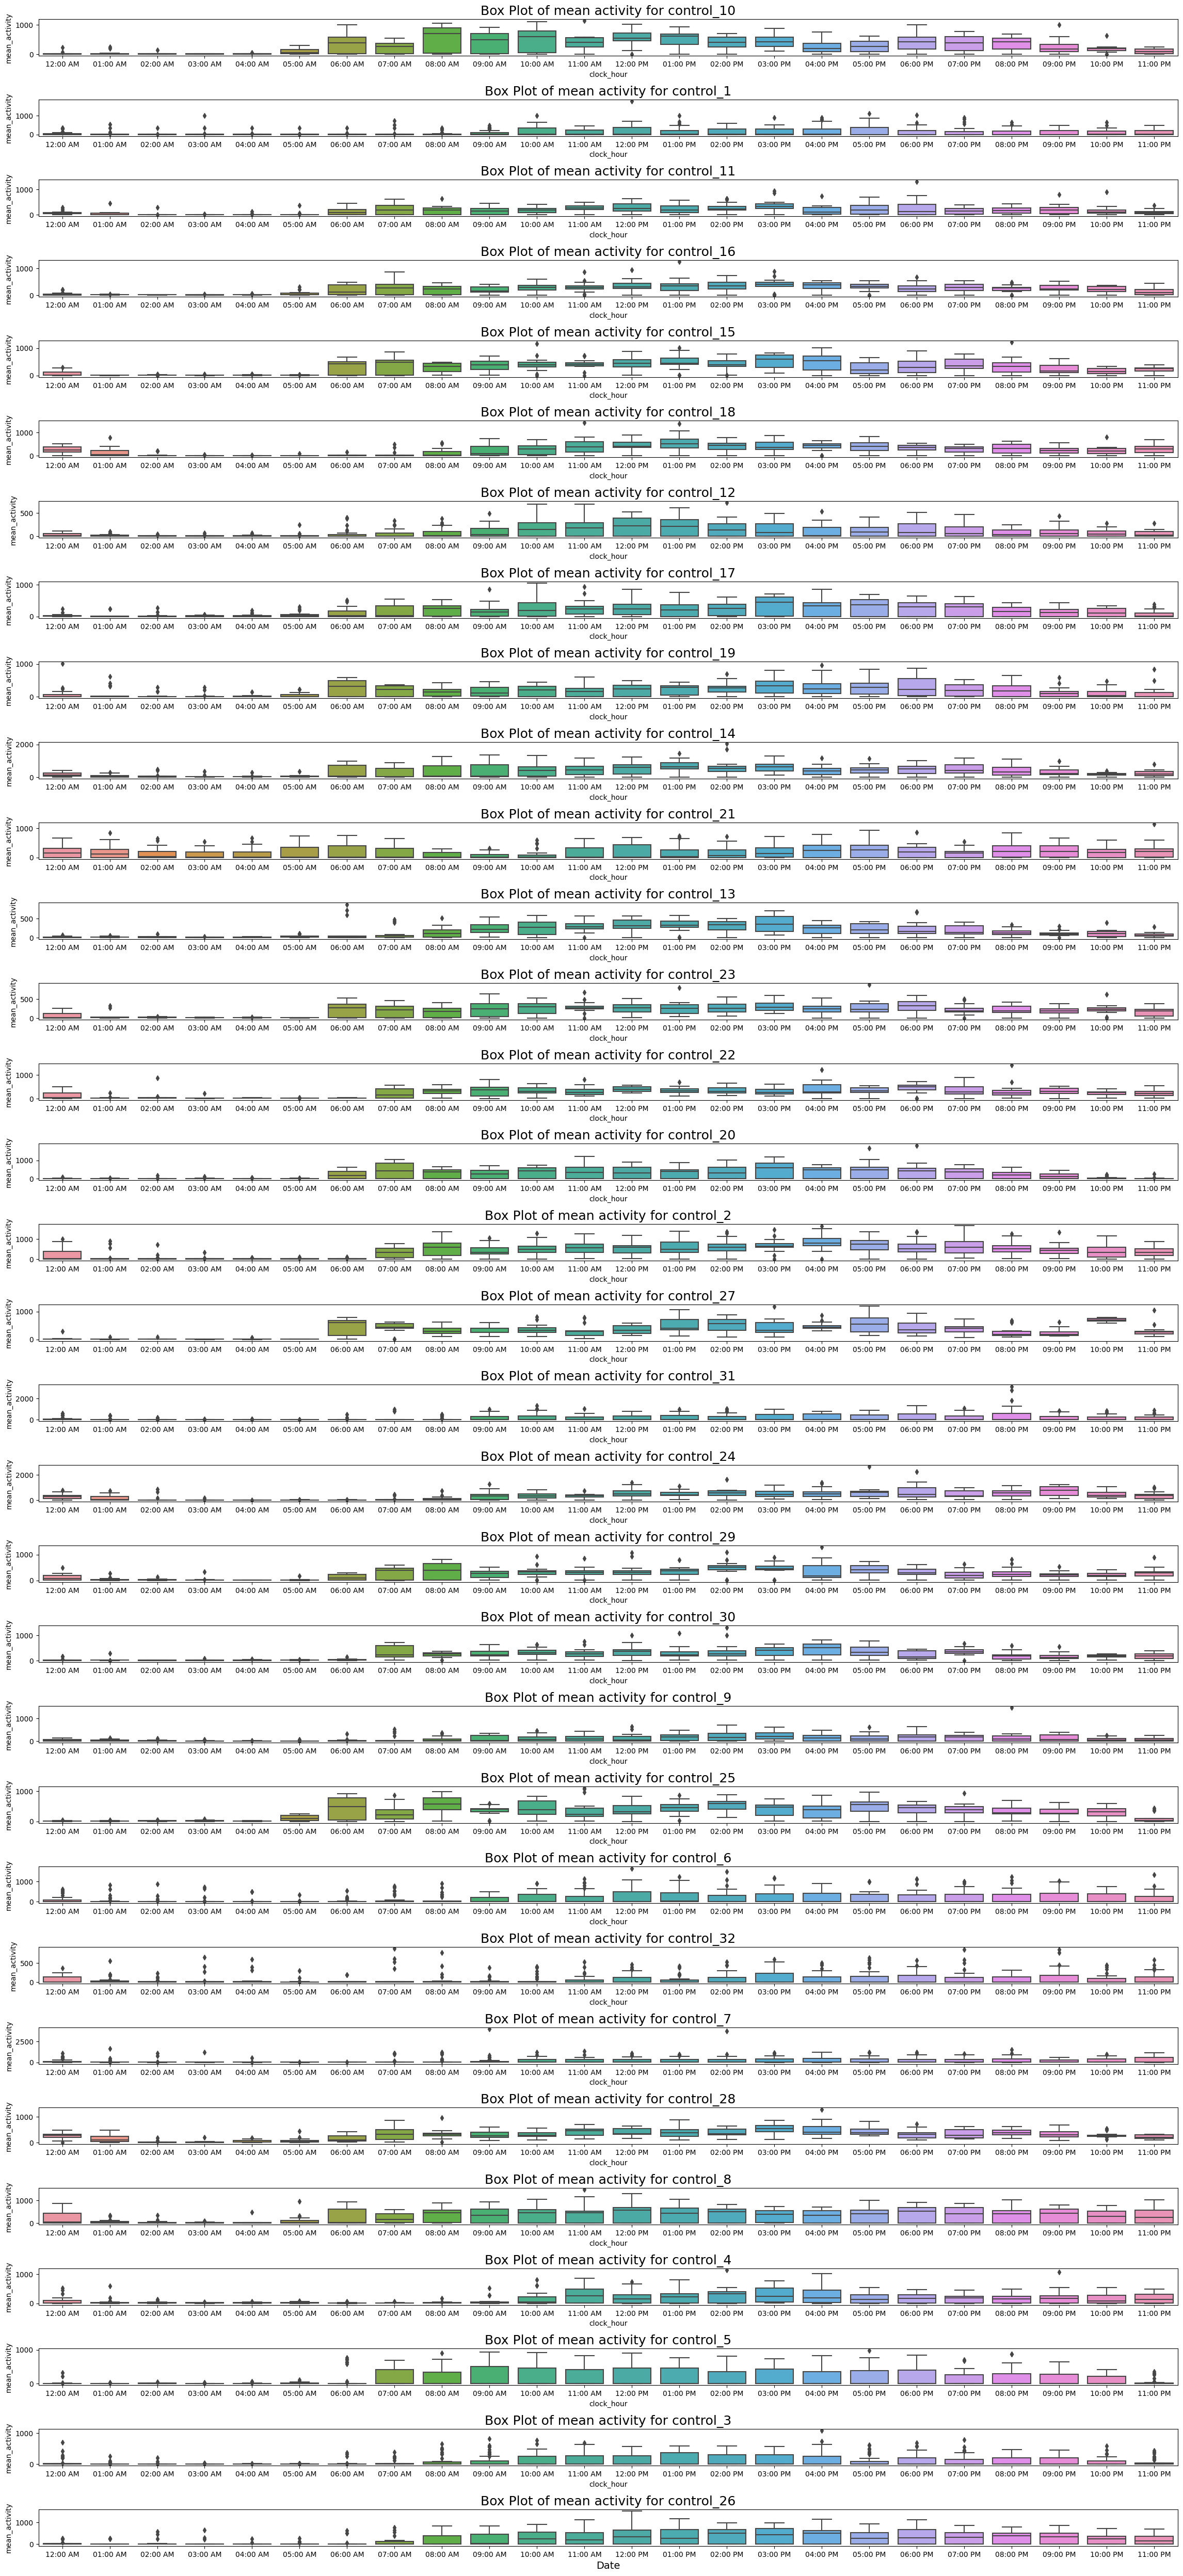

In [ ]:
# Draw Plot
fig, axes = plt.subplots(32, 1, figsize=(23, 50))

cnt = 0
for i in range(32):
    df = controls[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

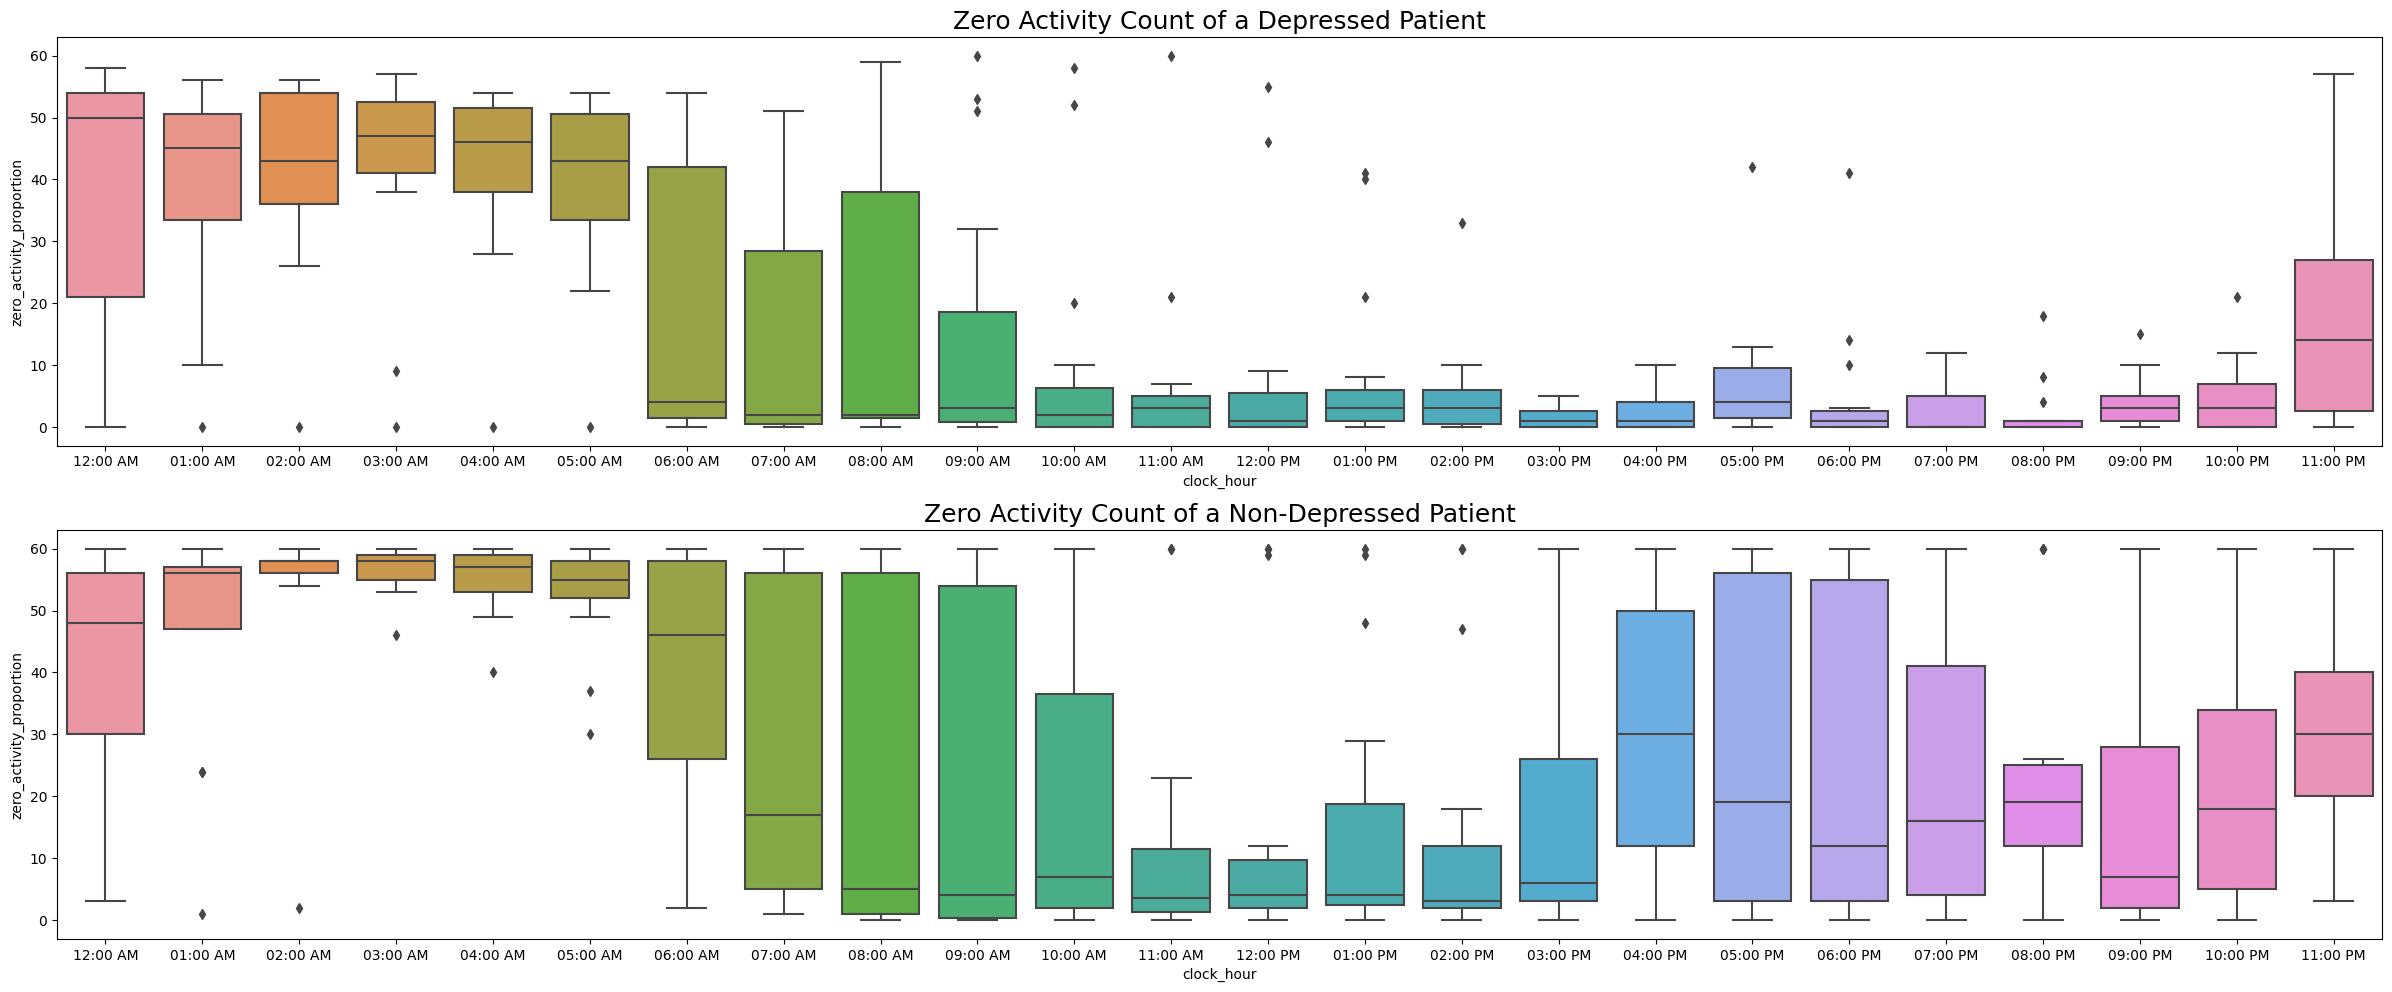

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(24, 10))
df = conditions[12].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[0])
axes[0].set_title('Zero Activity Count of a Depressed Patient', fontsize=18)

df = controls[2].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[1])
axes[1].set_title('Zero Activity Count of a Non-Depressed Patient', fontsize=18)

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
def nextday(dates):
    for date in dates:
        yield date

In [ ]:
def zero_count(series):
    return list(series).count(0)

In [ ]:
def extractfeatures(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': zero_count(X[mask]['log_activity'])
    }
    return d

In [ ]:
class ExtractData(BaseEstimator, TransformerMixin):
    
    def __init__(self, path):
        self.path = path
        self.X = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dirs = os.listdir(self.path)
        
        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(self.path + filepath)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()
                
                for date in nextday(dates):
                    d = extractfeatures(X, date)
                    d['source'] = condition
                    self.X.append(d)
                

        return pd.DataFrame(self.X)

In [ ]:
e = ExtractData(path='/content/drive/MyDrive/data/condition/') #condition path
conditions = e.fit_transform(X=None, y=None)
conditions['state'] = 1

In [ ]:
full_df = conditions.append(conditions, ignore_index=True)
full_df.head()

<ipython-input-39-3f36ed2c4913>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = conditions.append(conditions, ignore_index=True)


mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
0           3.752204          2.232849               0.0          7.734121   
1           2.931977          2.654278               0.0          7.578145   
2           2.593095          2.581104               0.0          7.422374   
3           2.910573          2.495671               0.0          7.671827   
4           2.561446          2.411986               0.0          7.640604   

   zero_proportion_activity       source  state  
0                       147  condition_1      1  
1                       589  condition_1      1  
2                       665  condition_1      1  
3                       539  condition_1      1  
4                       605  condition_1      1

In [ ]:
condition2=full_df[['mean_log_activity','zero_proportion_activity','state']]

In [ ]:
condition2.shape

(810, 3)

In [ ]:
conditions.tail()

mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
400           3.268575          2.714910               0.0          8.095904   
401           3.224212          2.608045               0.0          7.786552   
402           3.145590          2.666937               0.0          7.631917   
403           1.631725          2.351342               0.0          7.879670   
404           0.360103          1.339530               0.0          7.353082   

     zero_proportion_activity       source  state  
400                       504  condition_5      1  
401                       482  condition_5      1  
402                       521  condition_5      1  
403                       917  condition_5      1  
404                       485  condition_5      1

In [ ]:
e = ExtractData(path='/content/drive/MyDrive/data/control/') #control path
controls = e.fit_transform(X=None, y=None)
controls['state'] = 0

In [ ]:
full_df = controls.append(conditions, ignore_index=True)
full_df.head()

<ipython-input-44-156b248be5eb>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = controls.append(conditions, ignore_index=True)


mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
0           3.476942          2.493579               0.0          8.137103   
1           3.176251          2.957471               0.0          7.796058   
2           3.842992          2.833676               0.0          7.982758   
3           2.757899          2.967238               0.0          7.858254   
4           2.443912          2.084058               0.0          7.578145   

   zero_proportion_activity      source  state  
0                       185  control_10      0  
1                       616  control_10      0  
2                       434  control_10      0  
3                       713  control_10      0  
4                       146  control_10      0

In [ ]:
full_df1= full_df[['mean_log_activity','zero_proportion_activity','state']]#control

In [ ]:
full_df1.shape

(1144, 3)

In [ ]:
full_df1.head()

mean_log_activity  zero_proportion_activity  state
0           3.476942                       185      0
1           3.176251                       616      0
2           3.842992                       434      0
3           2.757899                       713      0
4           2.443912                       146      0

In [ ]:
condition2.head()

mean_log_activity  zero_proportion_activity  state
0           3.752204                       147      1
1           2.931977                       589      1
2           2.593095                       665      1
3           2.910573                       539      1
4           2.561446                       605      1

In [ ]:
combo=[full_df1,condition2]
result = pd.concat(combo)

In [ ]:
result.head()

mean_log_activity  zero_proportion_activity  state
0           3.476942                       185      0
1           3.176251                       616      0
2           3.842992                       434      0
3           2.757899                       713      0
4           2.443912                       146      0

In [ ]:
result.tail()

mean_log_activity  zero_proportion_activity  state
805           3.268575                       504      1
806           3.224212                       482      1
807           3.145590                       521      1
808           1.631725                       917      1
809           0.360103                       485      1

In [ ]:
result = result.sample(frac=1).reset_index(drop=True)

In [ ]:
result.shape

(1954, 3)

In [ ]:
result.tail()

mean_log_activity  zero_proportion_activity  state
1949           3.023057                       608      1
1950           2.291635                         0      1
1951           2.333844                       630      1
1952           3.838525                       439      0
1953           0.005154                      1437      0

In [ ]:
X=result[['mean_log_activity','zero_proportion_activity']].values
y=result['state']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# reshape the input data for LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [ ]:
# define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# train the LSTM model
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
49/49 [==============================] - 0s 7ms/step - loss: 0.5784 - accuracy: 0.6955 - val_loss: 0.5749 - val_accuracy: 0.7187
Epoch 2/200
49/49 [==============================] - 0s 5ms/step - loss: 0.6001 - accuracy: 0.6993 - val_loss: 0.6194 - val_accuracy: 0.6726
Epoch 3/200
49/49 [==============================] - 0s 5ms/step - loss: 0.5913 - accuracy: 0.6910 - val_loss: 0.5897 - val_accuracy: 0.6829
Epoch 4/200
49/49 [==============================] - 0s 4ms/step - loss: 0.6020 - accuracy: 0.6801 - val_loss: 0.5681 - val_accuracy: 0.7059
Epoch 5/200
49/49 [==============================] - 0s 4ms/step - loss: 0.5826 - accuracy: 0.7076 - val_loss: 0.5826 - val_accuracy: 0.6854
Epoch 6/200
49/49 [==============================] - 0s 4ms/step - loss: 0.5837 - accuracy: 0.6903 - val_loss: 0.5689 - val_accuracy: 0.7008
Epoch 7/200
49/49 [==============================] - 0s 5ms/step - loss: 0.5741 - accuracy: 0.7134 - val_loss: 0.5680 - val_accuracy: 0.6982
Epoch 8/200
4

In [ ]:
# evaluate the LSTM model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

13/13 [==============================] - 0s 2ms/step - loss: 0.5595 - accuracy: 0.7263
Test accuracy: 0.7263427376747131


In [ ]:
# make predictions with the LSTM model
y_pred = model.predict(X_test)

13/13 [==============================] - 0s 3ms/step
